In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')

### Подготовка данных

In [3]:
# заполняем пропуски медианой
df = df.fillna(df.median())
print(df.shape)
total_nan = df.isnull().sum().sum()
print(f"Общее количество NaN: {total_nan}")

(1001, 214)
Общее количество NaN: 0


In [5]:
# устранение выбросов
Q1 = df['IC50, mM'].quantile(0.25)
Q3 = df['IC50, mM'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['IC50, mM'] >= lower_bound) & (df['IC50, mM'] <= upper_bound)]

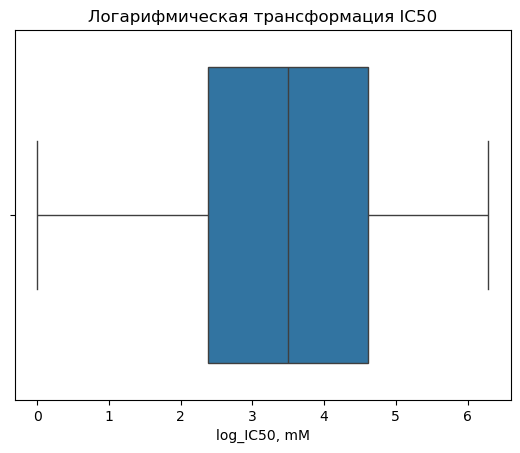

In [9]:
# Логарифмическая трансформация
df['log_IC50, mM'] = np.log(df['IC50, mM'] + 1)
sns.boxplot(x=df['log_IC50, mM'])
plt.title('Логарифмическая трансформация IC50')
plt.show()

In [11]:
df = df.drop(df.columns[[0]], axis=1)

In [13]:
df = df.drop(df.columns[[0]], axis=1)

In [15]:
df = df.drop(df.columns[[1]], axis=1)
df.head()

,"CC50, mM",MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,"log_IC50, mM"
0,175.482382,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,...,0,0,0,0,0,0,0,3,0,1.979535
1,5.402819,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,...,0,0,0,0,0,0,0,3,0,0.572014
2,161.142320,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,...,0,0,0,0,0,0,0,3,0,5.415250
3,107.855654,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,...,0,0,0,0,0,0,0,4,0,0.995333
4,139.270991,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,...,0,0,0,0,0,0,0,0,0,4.683348


In [17]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,"log_IC50, mM"
0,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,...,0,0,0,0,0,0,0,3,0,1.979535
1,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,...,0,0,0,0,0,0,0,3,0,0.572014
2,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,...,0,0,0,0,0,0,0,3,0,5.415250
3,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,164,...,0,0,0,0,0,0,0,4,0,0.995333
4,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,...,0,0,0,0,0,0,0,0,0,4.683348


In [19]:
# добавление фичей
df['Mol_properties_ratio'] = df['HeavyAtomMolWt'] / df['MolWt']
df['Electron_density'] = df['NumValenceElectrons'] / df['HeavyAtomCount']

df['Charge_imbalance'] = df['MaxPartialCharge'] - df['MinPartialCharge']
df['Abs_charge_range'] = df['MaxAbsPartialCharge'] - df['MinAbsPartialCharge']

df['Topological_complexity'] = df['Chi0'] + df['Chi1'] + df['Kappa1'] + df['Kappa2']
peoe_cols = [col for col in df.columns if 'PEOE_VSA' in col]
smr_cols = [col for col in df.columns if 'SMR_VSA' in col]

df['PEOE_VSA_total'] = df[peoe_cols].sum(axis=1)
df['SMR_VSA_total'] = df[smr_cols].sum(axis=1)

fr_cols = [col for col in df.columns if col.startswith('fr_')]
df['Functional_groups_total'] = df[fr_cols].sum(axis=1)

df['H_bond_groups'] = df['NumHAcceptors'] + df['NumHDonors']

df['Ring_complexity'] = (
    df['NumAromaticRings']
    + df['NumAliphaticRings']
    + df['NumSaturatedRings']
)

# удаление исходных фичей
columns_to_drop = peoe_cols + smr_cols + fr_cols + [
    'HeavyAtomMolWt', 'MolWt', 'NumValenceElectrons', 'HeavyAtomCount',
    'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
    'Chi0', 'Chi1', 'Kappa1', 'Kappa2',
    'NumHAcceptors', 'NumHDonors',
    'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings'
]

df.drop(columns=columns_to_drop, inplace=True)

In [21]:
# анализ мультиколинеарности и отбор фичей
target_vars = ['log_IC50, mM']
numeric_features = df.select_dtypes(include=np.number)

# анализ корреляционной матрицы между признаками
corr_matrix = numeric_features.corr()
# пары признаков с высокой корреляцией (>0.8 или <-0.8)
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in corr_matrix.columns for col2 in corr_matrix.columns
                   if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.8]
print("Пары признаков с высокой корреляцией (>0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: корреляция = {pair[2]:.2f}")

# VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features.columns

vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i)
                   for i in range(numeric_features.shape[1])]
print("\nПризнаки с высоким VIF (более 5):")
for index, row in vif_data.iterrows():
    if row['VIF'] > 5:
        print(f"{row['feature']}: VIF = {row['VIF']:.2f}")

# корреляция признаков с целевыми переменными
corr_with_targets = pd.DataFrame(index=numeric_features.columns)
for target in target_vars:
    corr_with_targets[target] = numeric_features.corrwith(df[target])

# удаление признаков
features_to_remove = set()
for col1, col2, corr_value in high_corr_pairs:
    # проверка наличия высокой корреляции с таргетом у каждого признака
    corr_col1_targets = corr_with_targets.loc[col1].abs()
    corr_col2_targets = corr_with_targets.loc[col2].abs()

    col1_has_target_corr = any(corr_col1_targets > 0.2)
    col2_has_target_corr = any(corr_col2_targets > 0.2)
    if not col1_has_target_corr and not col2_has_target_corr:
        features_to_remove.add(col2)
print("\nПризнаки для удаления из-за мультиколлинеарности без связи с таргетом:")
for feature in features_to_remove:
    print(feature)

# итоговый набор признаков после удаления
final_features = [col for col in numeric_features.columns if col not in features_to_remove]
print("\nОставшиеся признаки после удаления:")
print(final_features)

df_final = df[final_features]

Пары признаков с высокой корреляцией (>0.8):
MaxAbsEStateIndex и MaxEStateIndex: корреляция = 1.00
MaxAbsEStateIndex и Charge_imbalance: корреляция = 0.81
MaxEStateIndex и MaxAbsEStateIndex: корреляция = 1.00
MaxEStateIndex и Charge_imbalance: корреляция = 0.81
SPS и FractionCSP3: корреляция = 0.86
ExactMolWt и BertzCT: корреляция = 0.90
ExactMolWt и Chi0n: корреляция = 0.93
ExactMolWt и Chi0v: корреляция = 0.95
ExactMolWt и Chi1n: корреляция = 0.90
ExactMolWt и Chi1v: корреляция = 0.92
ExactMolWt и LabuteASA: корреляция = 0.99
ExactMolWt и MolMR: корреляция = 0.96
ExactMolWt и Topological_complexity: корреляция = 0.98
ExactMolWt и PEOE_VSA_total: корреляция = 0.99
ExactMolWt и SMR_VSA_total: корреляция = 0.99
ExactMolWt и Functional_groups_total: корреляция = 0.81
FpDensityMorgan1 и FpDensityMorgan2: корреляция = 0.95
FpDensityMorgan2 и FpDensityMorgan1: корреляция = 0.95
FpDensityMorgan2 и FpDensityMorgan3: корреляция = 0.94
FpDensityMorgan3 и FpDensityMorgan2: корреляция = 0.94
BCUT

In [22]:
df_final.head()

,MinAbsEStateIndex,MinEStateIndex,qed,NumRadicalElectrons,BCUT2D_MWLOW,BCUT2D_MRLOW,AvgIpc,BalabanJ,Ipc,SlogP_VSA1,...,VSA_EState7,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,NumAromaticHeterocycles,NumSaturatedHeterocycles,MolLogP,"log_IC50, mM",Abs_charge_range
0,0.387225,0.387225,0.417362,0,9.700470,0.193481,3.150503,1.164038,2.187750e+06,0.000000,...,13.258223,16.981087,0.000000,0,0,0,0,7.1212,1.979535,0.254682
1,0.533868,0.533868,0.462473,0,9.689226,0.120322,3.150503,1.080362,2.187750e+06,10.633577,...,14.135381,17.670565,0.000000,2,0,0,0,6.1556,0.572014,0.300521
2,0.543231,0.543231,0.260923,0,9.681293,-0.922902,3.214947,1.219066,8.610751e+06,0.000000,...,14.491619,18.287216,10.183618,0,0,0,0,7.1292,5.415250,0.230772
3,0.390603,0.390603,0.377846,0,9.700497,0.193510,3.179270,1.120513,3.572142e+06,0.000000,...,14.695439,17.012013,0.000000,0,0,0,0,7.5113,0.995333,0.254682
4,0.270476,0.270476,0.429038,0,9.700386,0.193687,3.337074,1.136678,1.053758e+08,0.000000,...,8.627311,14.692318,0.000000,0,0,0,0,9.1148,4.683348,0.194342


In [25]:
# 20 самых важных признаков
X = df_final.drop(columns=['log_IC50, mM'])
y = df_final['log_IC50, mM']

importances = mutual_info_regression(X, y)

feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("20 самых важных признаков для IC50 по их значимости:")
print(feature_importances.head(20))

20 самых важных признаков для IC50 по их значимости:
VSA_EState8         0.261773
BCUT2D_MWLOW        0.259636
Abs_charge_range    0.250819
BCUT2D_MRLOW        0.232439
BalabanJ            0.225530
SlogP_VSA5          0.212795
EState_VSA2         0.207115
AvgIpc              0.206646
SlogP_VSA2          0.203511
VSA_EState5         0.202408
VSA_EState4         0.194661
MinEStateIndex      0.190350
VSA_EState7         0.188325
VSA_EState2         0.179318
NHOHCount           0.174056
VSA_EState3         0.172894
EState_VSA9         0.170111
MolLogP             0.168298
EState_VSA8         0.160308
EState_VSA6         0.152652
dtype: float64


In [27]:
# удаление признаков с важностью менее 0.1
features_to_keep = feature_importances[feature_importances >= 0.15].index
X_drop = X[features_to_keep]

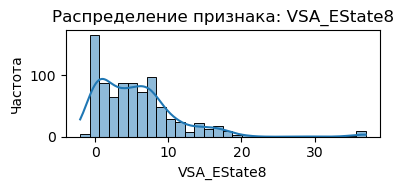

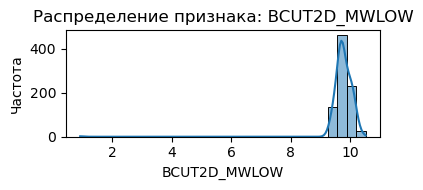

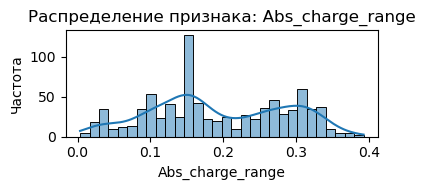

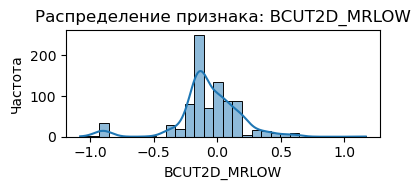

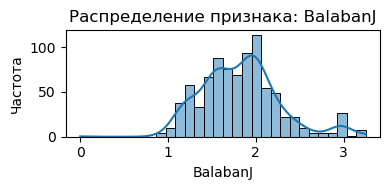

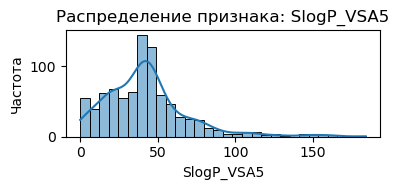

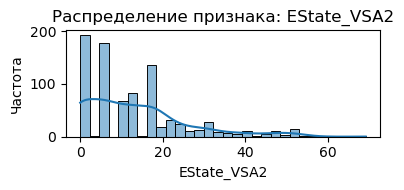

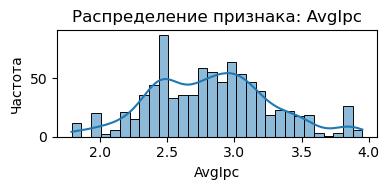

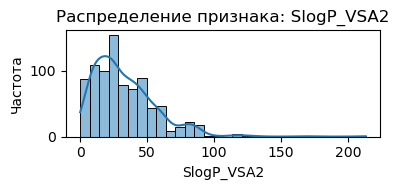

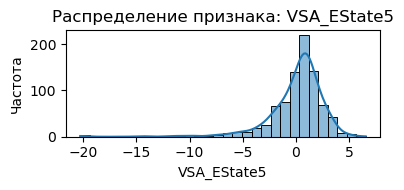

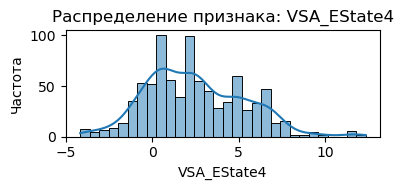

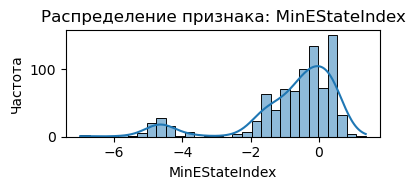

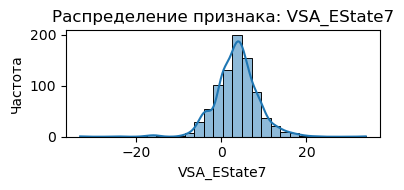

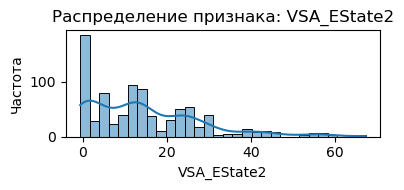

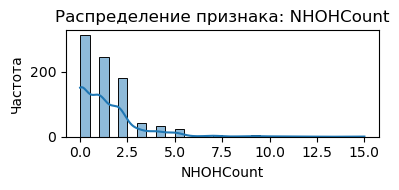

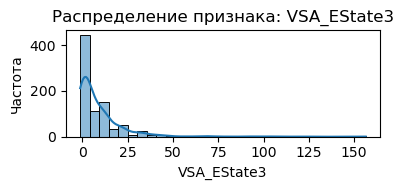

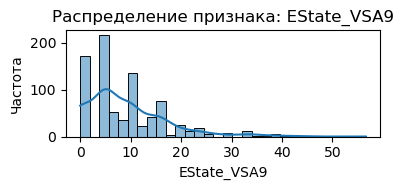

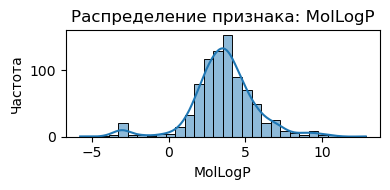

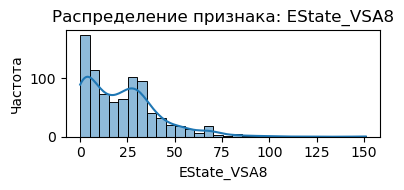

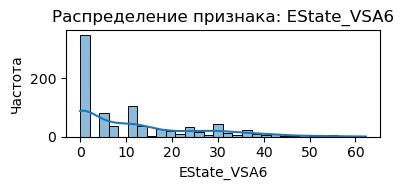

In [29]:
# построение графиков распределения оставшихся признаков
for feature in features_to_keep:
    plt.figure(figsize=(4, 2))
    sns.histplot(X_drop[feature], bins=30, kde=True)
    plt.title(f'Распределение признака: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.tight_layout() 
    plt.show()

In [31]:
# логарифмизация признаков
skewness = X_drop.skew()
print(skewness[skewness.abs() > 1])
features_to_log = skewness[skewness > 1].index

print("Признаки для логарифмирования IC50:", list(features_to_log))

for feature in features_to_log:
    min_value = X_drop[feature].min()
    if min_value <= 0:
        shift_value = abs(min_value) + 1e-9
        X_drop[feature] = np.log(X_drop[feature] + shift_value)
    else:
        X_drop[feature] = np.log(X_drop[feature])

VSA_EState8        2.198320
BCUT2D_MWLOW     -14.316253
SlogP_VSA5         1.426193
EState_VSA2        1.227072
SlogP_VSA2         1.616195
VSA_EState5       -2.764575
MinEStateIndex    -1.783467
VSA_EState2        1.144329
NHOHCount          2.658587
VSA_EState3        4.191391
EState_VSA9        1.678903
EState_VSA8        1.328023
EState_VSA6        1.166108
dtype: float64
Признаки для логарифмирования IC50: ['VSA_EState8', 'SlogP_VSA5', 'EState_VSA2', 'SlogP_VSA2', 'VSA_EState2', 'NHOHCount', 'VSA_EState3', 'EState_VSA9', 'EState_VSA8', 'EState_VSA6']


In [33]:
# замена выбросов на границы интервала (IQR) для всех признаков
for feature in X_drop.columns:
    Q1 = X_drop[feature].quantile(0.25)
    Q3 = X_drop[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    before_values = X_drop[feature].copy()
    X_drop.loc[X_drop[feature] < lower_bound, feature] = lower_bound
    X_drop.loc[X_drop[feature] > upper_bound, feature] = upper_bound
    
    num_lower_replacements = (before_values < lower_bound).sum()
    num_upper_replacements = (before_values > upper_bound).sum()
    
    print(f"В признаке '{feature}': заменено {num_lower_replacements} значений ниже нижней границы и {num_upper_replacements} выше верхней границы.")

В признаке 'VSA_EState8': заменено 2 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'BCUT2D_MWLOW': заменено 2 значений ниже нижней границы и 3 выше верхней границы.
В признаке 'Abs_charge_range': заменено 0 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'BCUT2D_MRLOW': заменено 36 значений ниже нижней границы и 24 выше верхней границы.
В признаке 'BalabanJ': заменено 1 значений ниже нижней границы и 39 выше верхней границы.
В признаке 'SlogP_VSA5': заменено 65 значений ниже нижней границы и 1 выше верхней границы.
В признаке 'EState_VSA2': заменено 192 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'AvgIpc': заменено 0 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'SlogP_VSA2': заменено 11 значений ниже нижней границы и 1 выше верхней границы.
В признаке 'VSA_EState5': заменено 43 значений ниже нижней границы и 1 выше верхней границы.
В признаке 'VSA_EState4': заменено 0 значений ниже нижней границы и 8 выше 

In [35]:
X_drop.head()

,VSA_EState8,BCUT2D_MWLOW,Abs_charge_range,BCUT2D_MRLOW,BalabanJ,SlogP_VSA5,EState_VSA2,AvgIpc,SlogP_VSA2,VSA_EState5,VSA_EState4,MinEStateIndex,VSA_EState7,VSA_EState2,NHOHCount,VSA_EState3,EState_VSA9,MolLogP,EState_VSA8,EState_VSA6
0,2.945262,9.700470,0.254682,0.193481,1.164038,4.661084,-0.066507,3.150503,3.199199,1.764908,4.807589,0.387225,13.258223,2.377852,-20.723266,0.229768,2.301065,7.1212,3.726715,2.435661
1,2.980878,9.689226,0.300521,0.120322,1.080362,4.661084,-0.066507,3.150503,3.225780,1.914377,2.153503,0.533868,14.135381,-0.521666,0.693147,2.217152,-0.058411,6.1556,3.954623,-20.723266
2,3.011693,9.681293,0.230772,-0.487544,1.219066,4.661084,-0.066507,3.214947,4.132442,1.930720,2.184127,0.543231,14.491619,-0.521666,-20.723266,0.229768,-0.058411,7.1292,4.244675,-20.723266
3,2.946887,9.700497,0.254682,0.193510,1.120513,4.720029,-0.066507,3.179270,3.199199,1.769975,4.827852,0.390603,14.695439,2.378458,-20.723266,0.229768,2.301065,7.5113,3.726715,2.435661
4,2.817017,9.700386,0.194342,0.193687,1.136678,4.512992,2.382318,3.337074,2.435661,1.605178,9.071783,0.270476,8.627311,2.388263,-20.723266,0.229768,2.301065,7.8683,4.500624,-20.723266


In [37]:
# стандартизация
std = StandardScaler()
std.fit(X_drop)
X_std = std.transform(X_drop)
X_std_df = pd.DataFrame(X_std, columns=X_drop.columns)
print("Стандартизированные данные:")
X_std_df.head()

Стандартизированные данные:


,VSA_EState8,BCUT2D_MWLOW,Abs_charge_range,BCUT2D_MRLOW,BalabanJ,SlogP_VSA5,EState_VSA2,AvgIpc,SlogP_VSA2,VSA_EState5,VSA_EState4,MinEStateIndex,VSA_EState7,VSA_EState2,NHOHCount,VSA_EState3,EState_VSA9,MolLogP,EState_VSA8,EState_VSA6
0,1.551308,-0.398886,0.667087,1.279154,-1.550720,1.629604,-1.651637,0.731367,-0.042489,0.763471,0.824885,0.952356,2.107981,0.215241,-1.316649,-1.133057,0.493881,1.946135,0.837686,0.797457
1,1.599246,-0.448983,1.164788,0.900152,-1.749487,1.629604,-1.651637,0.731367,-0.008039,0.838789,-0.113657,1.079462,2.300754,-1.790845,0.772657,0.495624,-1.715492,1.404929,0.971191,-1.210468
2,1.640720,-0.484332,0.407480,-2.248939,-1.420003,1.629604,-1.651637,0.877520,1.167042,0.847024,-0.102827,1.087577,2.379045,-1.790845,-1.316649,-1.133057,-1.715492,1.950619,1.141099,-1.210468
3,1.553496,-0.398764,0.667087,1.279307,-1.654110,1.715064,-1.651637,0.796608,-0.042489,0.766024,0.832050,0.955284,2.423838,0.215660,-1.316649,-1.133057,0.493881,2.164781,0.837686,0.797457
4,1.378700,-0.399261,0.011937,1.280220,-1.615711,1.414896,0.279567,1.154489,-1.032073,0.682982,2.332794,0.851162,1.090242,0.222444,-1.316649,-1.133057,0.493881,2.364874,1.291029,-1.210468


In [39]:
# нормализация
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_drop)
X_normalized_df = pd.DataFrame(X_normalized, columns=X_drop.columns)
print("Нормализованные данные:")
X_normalized_df.head()

Нормализованные данные:


,VSA_EState8,BCUT2D_MWLOW,Abs_charge_range,BCUT2D_MRLOW,BalabanJ,SlogP_VSA5,EState_VSA2,AvgIpc,SlogP_VSA2,VSA_EState5,VSA_EState4,MinEStateIndex,VSA_EState7,VSA_EState2,NHOHCount,VSA_EState3,EState_VSA9,MolLogP,EState_VSA8,EState_VSA6
0,0.821622,0.387107,0.645438,0.763028,0.204169,0.856426,0.000000,0.629530,0.479465,0.648633,0.591934,0.797089,0.929476,0.636722,0.000000,0.421537,0.576249,0.912186,0.787299,0.931792
1,0.830462,0.377033,0.763167,0.681061,0.164176,0.856426,0.000000,0.629530,0.485970,0.664253,0.417352,0.827224,0.968017,0.064302,0.914008,0.659535,0.000000,0.798691,0.824870,0.000000
2,0.838109,0.369924,0.584030,0.000000,0.230470,0.856426,0.000000,0.659294,0.707866,0.665961,0.419366,0.829148,0.983669,0.064302,0.000000,0.421537,0.000000,0.913127,0.872686,0.000000
3,0.822026,0.387132,0.645438,0.763061,0.183366,0.875149,0.000000,0.642816,0.479465,0.649163,0.593267,0.797783,0.992624,0.636842,0.000000,0.421537,0.576249,0.958039,0.787299,0.931792
4,0.789794,0.387032,0.490466,0.763259,0.191092,0.809386,0.568973,0.715700,0.292597,0.631941,0.872428,0.773096,0.726006,0.638777,0.000000,0.421537,0.576249,1.000000,0.914880,0.000000


In [41]:
# разделение датасета на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.15, random_state=42)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (725, 20), (725,)
Train dataset size: (129, 20), (129,)


### Обучение моделей

In [45]:
models = {
    'Linear Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]),
    'KNN (KNeighborsRegressor)': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor(n_neighbors=5))
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    'HistGradientBoosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', HistGradientBoostingRegressor(random_state=42))
    ]),
    'AdaBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', AdaBoostRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', xgb.XGBRegressor(random_state=42, verbosity=0))
    ]),
    'LightGBM': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', lgb.LGBMRegressor(random_state=42))
    ]),
    'CatBoost Regressor': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', CatBoostRegressor(
            random_seed=42,
            verbose=0 
        ))
    ])
}

# обучение и оценка моделей
results = {}
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
    print(f"{name}: MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}")

# подбор гиперпараметров для лучшей модели
param_grid_cb = {
    'model__iterations': [100, 200],
    'model__depth': [4, 6],
    'model__learning_rate': [0.01, 0.1],
}

grid_search_cb = GridSearchCV(
    models['CatBoost Regressor'],
    param_grid_cb,
    cv=5,
    scoring='neg_mean_squared_error'
)

grid_search_cb.fit(X_train, y_train)

print("Лучшие параметры для CatBoost:", grid_search_cb.best_params_)
print("Лучший результат (по MAPE):", -grid_search_cb.best_score_)
print("Лучший результат (по MSE):", -grid_search_cb.best_score_)

Linear Regression: MSE = 1.86, MAE = 1.13, R2 = 0.18
Ridge Regression: MSE = 1.86, MAE = 1.13, R2 = 0.18
KNN (KNeighborsRegressor): MSE = 1.56, MAE = 0.98, R2 = 0.31
Random Forest: MSE = 1.28, MAE = 0.88, R2 = 0.44
Gradient Boosting: MSE = 1.35, MAE = 0.94, R2 = 0.40
HistGradientBoosting: MSE = 1.33, MAE = 0.89, R2 = 0.41
AdaBoost: MSE = 1.39, MAE = 0.99, R2 = 0.38
XGBoost: MSE = 1.55, MAE = 0.94, R2 = 0.31
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3756
[LightGBM] [Info] Number of data points in the train set: 725, number of used features: 20
[LightGBM] [Info] Start training from score 3.510229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

╒═══════════════════════════╤════════╤════════╤════════╕
│                           │    MSE │    MAE │     R2 │
╞═══════════════════════════╪════════╪════════╪════════╡
│ Linear Regression         │ 1.8563 │ 1.1277 │ 0.1778 │
├───────────────────────────┼────────┼────────┼────────┤
│ Ridge Regression          │ 1.8552 │ 1.1272 │ 0.1783 │
├───────────────────────────┼────────┼────────┼────────┤
│ KNN (KNeighborsRegressor) │ 1.5588 │ 0.9771 │ 0.3096 │
├───────────────────────────┼────────┼────────┼────────┤
│ Random Forest             │ 1.2753 │ 0.8815 │ 0.4352 │
├───────────────────────────┼────────┼────────┼────────┤
│ Gradient Boosting         │ 1.3545 │ 0.9363 │ 0.4001 │
├───────────────────────────┼────────┼────────┼────────┤
│ HistGradientBoosting      │ 1.3255 │ 0.8892 │ 0.4129 │
├───────────────────────────┼────────┼────────┼────────┤
│ AdaBoost                  │ 1.3933 │ 0.9924 │ 0.3829 │
├───────────────────────────┼────────┼────────┼────────┤
│ XGBoost                   │ 1

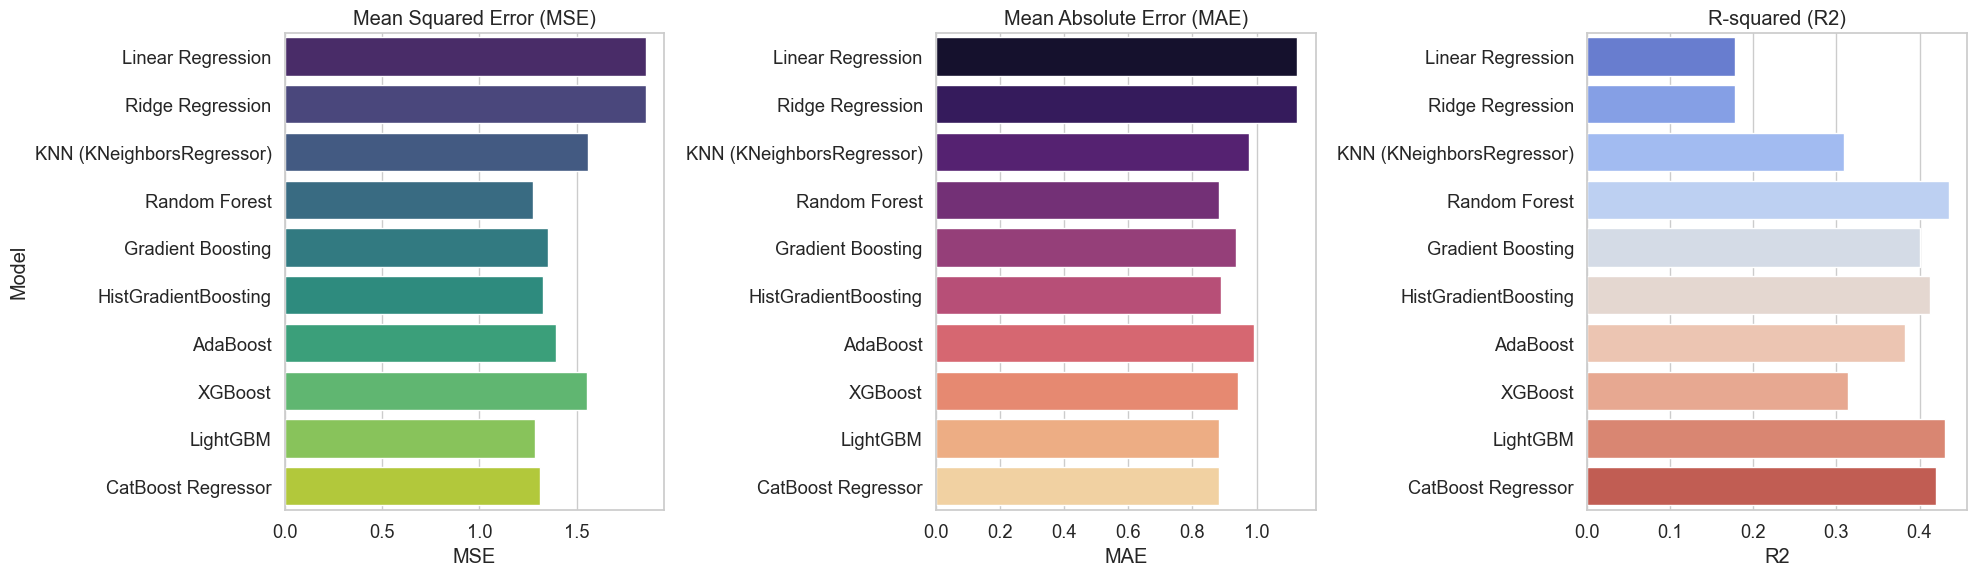

In [46]:
# визуализация результатов
results_df = pd.DataFrame(results).T  
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))


results_df = pd.DataFrame(results).T 
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(
    x='MSE',
    y=results_df.index,
    data=results_df,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('Model')

sns.barplot(
    x='MAE',
    y=results_df.index,
    data=results_df,
    ax=axes[1],
    palette='magma'
)
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('')

sns.barplot(
    x='R2',
    y=results_df.index,
    data=results_df,
    ax=axes[2],
    palette='coolwarm'
)
axes[2].set_title('R-squared (R2)')
axes[2].set_xlabel('R2')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

In [62]:
# вычисление MAPE
results_mape = []

for name, pipeline in models.items():
    y_pred = pipeline.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results_mape.append({'Модель': name, 'MAPE': mape})

results_df = pd.DataFrame(results_mape).sort_values(by='MAPE')

print(results_df.to_string(index=False))

                   Модель     MAPE
     HistGradientBoosting 0.884344
       CatBoost Regressor 0.896611
                 LightGBM 0.901288
            Random Forest 0.914815
                  XGBoost 0.930290
        Gradient Boosting 1.167349
KNN (KNeighborsRegressor) 1.309965
                 AdaBoost 1.736830
        Linear Regression 2.101955
         Ridge Regression 2.103536


### Побдор гиперпараметров

In [49]:
# подбор гиперпараметров
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
    'KNN (KNeighborsRegressor)': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'HistGradientBoosting': {
        'model__max_iter': [100, 200],
        'model__max_depth': [None, 10]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.01, 0.1]
    },
    'LightGBM': {
        'model__n_estimators': [100, 200],
        'model__num_leaves': [31, 50],
        'model__learning_rate': [0.01, 0.1]
    },
    'CatBoost Regressor': {
        'model__iterations': [100, 200],
        'model__depth': [4, 6],
        'model__learning_rate': [0.01, 0.1]
    }
}

results = []

for name in models:
    print(f"\nОбучение и подбор гиперпараметров для {name}...")
    
    grid = GridSearchCV(
        models[name],
        param_grids.get(name, {}),
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_params = grid.best_params_
    

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best Params": best_params,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
     })

results_df = pd.DataFrame(results)
results_df['MSE'] = results_df['MSE'].round(3)
results_df['MAE'] = results_df['MAE'].round(3)
results_df['R2'] = results_df['R2'].round(3)

results_df['Best Params'] = results_df['Best Params'].apply(lambda x: str(x))

print("\nРезультаты моделей:")
print(tabulate(results_df.sort_values(by='R2'), headers='keys', tablefmt='fancy_grid', showindex=False))


Обучение и подбор гиперпараметров для Linear Regression...

Обучение и подбор гиперпараметров для Ridge Regression...

Обучение и подбор гиперпараметров для KNN (KNeighborsRegressor)...

Обучение и подбор гиперпараметров для Random Forest...

Обучение и подбор гиперпараметров для Gradient Boosting...

Обучение и подбор гиперпараметров для HistGradientBoosting...

Обучение и подбор гиперпараметров для AdaBoost...

Обучение и подбор гиперпараметров для XGBoost...

Обучение и подбор гиперпараметров для LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3756
[LightGBM] [Info] Number of data points in the train set: 725, number of used features: 20
[LightGBM] [Info] Start training from score 3.510229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai